In [1]:
import torch
import torchvision
import torch.nn
import torch.nn.functional as F
import cv2

%run Config.ipynb
%run Utils.ipynb
%run models.ipynb
%run Dataset_preparation.ipynb

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda


In [2]:
testset=Data(test_im, test_txt, test=True)
test=DataLoader(testset,shuffle=True,num_workers=0,batch_size=1)

In [3]:
model=CTPN()
model.to(device)
model.eval()
cc=torch.load(os.path.join(checkpoints_dir,os.listdir(checkpoints_dir)[-1]), map_location=device)
model.load_state_dict(cc['model_state_dict'])

<All keys matched successfully>

In [4]:
def dfs(coors, vis, ind, proposals, prop):
    
    if vis[ind]==1:
        return 
    
    vis[ind]=1
    
    coors[0]=min(coors[0], proposals[ind][0])
    coors[1]=min(coors[1], proposals[ind][1])
    coors[2]=max(coors[2], proposals[ind][2])
    coors[3]=max(coors[3], proposals[ind][3])
    
    for j in prop[ind]:
        dfs(coors, vis, j, proposals, prop)
        
    return

In [5]:
def text_connector(proposals):
    
    n=len(proposals)
    paired=[]
    
    for i in range(n):
        
        s=0
        dist=10000
        center=(proposals[i][0]+proposals[i][2])/2
        neighbour=[]
        paired.append([])
        
        for j in range(n):
            
            if i==j:
                continue
                
            temp=(proposals[j][0]+proposals[j][2])/2
            s=abs(center-temp)
            
            if s<dist:
                dist=s
                neighbour=[j]
                
            elif s==dist:
                neighbour.append(j)
        
        if dist<100:
            for j in neighbour:
            
                upper=max(proposals[i][1], proposals[j][1])
                lower=min(proposals[i][3], proposals[j][3])

                overlap=abs(upper-lower)
                
                if proposals[i][1]>proposals[j][3] or proposals[i][3]<proposals[j][1]:
                    overlap=0
                    
                else:
                    overlap=min(-proposals[i][1]+proposals[j][3], proposals[i][3]-proposals[j][1])
                    
                if overlap>0 and abs(proposals[i][1]-proposals[i][3])/overlap>0.7:
                    paired[i].append(j)
    
    prop=[]
    
    for i in range(n):
        prop.append([])
        for j in paired[i]:
            flag=0
            for h in paired[j]:
                
                if i==h:
                    flag=1
                    break
            if flag==1:
                prop[i].append(j)
        
    base=gen_anchor((height/16, width/16), 16)
    
    vis=np.zeros((n, 1))
    rect=[]
    for i in range(n):
        if vis[i]!=1:
            coors=[1000, 1000, 0, 0]
            dfs(coors, vis, i, proposals, prop)
            rect.append(coors)
            
    return rect

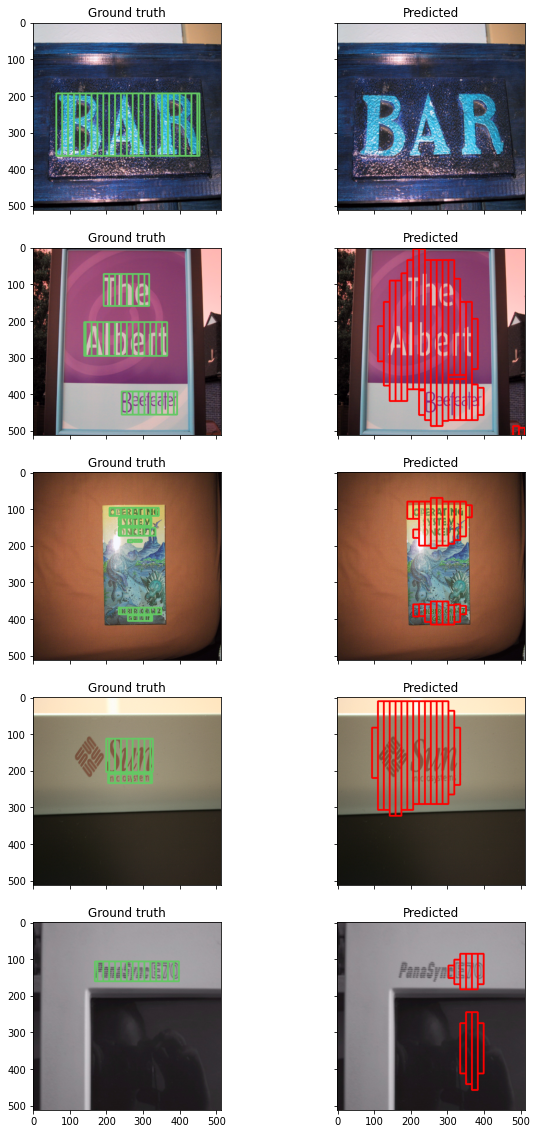

In [6]:
def pred(model):
    
    fig, ax=plt.subplots(5, 2, figsize=(10, 20), sharex=True, sharey=True)
    count=0
    for b, (d, img, regr, cls, refine) in enumerate(test):
        
        img=img.to(device)

        out_c, outr, _=model(img)
        out_c=out_c[0]
        outr=outr[0]
        out_c=F.softmax(out_c, dim=-1)
        base_anchors=gen_anchor((height/16, width/16), 16)
        
        ax[count, 0].imshow(d[0])
        ax[count, 0].set_title("Ground truth")

        d=img[0].long()
        d=np.transpose(d.cpu().numpy(), (1, 2, 0))
        d=cv2.resize(d,(height,width))

        proposals=[]
        
        for i in range(len(base_anchors)):
            
            if out_c[i][1]>0.7 and min(base_anchors[i])>0:
                cen, hght=outr[i]
                
                cen_a=(base_anchors[i][1]+base_anchors[i][3])/2
                hght_a=abs(base_anchors[i][1]-base_anchors[i][3])
                
                cen=cen*(hght_a)+cen_a
                
                hght=2.7**hght
                hght=hght*(hght_a)
                
                x1=int(base_anchors[i][0])
                y1=int(cen-(hght/2))
                x2=int(base_anchors[i][2])
                y2=int(cen+(hght/2))
                            
                proposals.append([x1, y1, x2, y2])
                
        rect=text_connector(proposals)
                
        for i in range(len(rect)):
            x1, y1, x2, y2=rect[i]
            cv2.rectangle(d, (x1, y1), (x2, y2), (255, 0, 0), 3)
        
        ax[count, 1].imshow(d)
        ax[count, 1].set_title("Predicted")
        
        count+=1
        if count==5:
            break
    plt.show()        
        
pred(model)       